In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
from qoptical import ReducedSystem, QO, time_gatter, opmesolve_cl_expect
# pyma repo
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib import hosci
from lib.probe import opmesolve_probe, jeff_fit_drude, load_fs, drude
QO.DEBUG = True

# Some Operators available, debug purpose only

In [3]:
# some available operators
#print('a');        print(hosci.Oa(5).real)
#print('ad');       print(hosci.Oad(5).real)
#print('a+ad');     print(hosci.Ophi(5).real)
#print('(a+ad)^2'); print(hosci.Ophi2(5).real)
#print('dn');       print(hosci.Odn(5).imag)
#print('n');        print(hosci.On(5).real)
print(hosci.hosci_rs(7, 1, 9).h0)

[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  3.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  6.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  9.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j 12.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j 15.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j 18.+0.j]]


# Linear Response
Parametric driving

In [4]:
### system  #########################
dimH  = 9  
EC    = 2              # CHARGE ENERGY
EJ    = 9.0 / EC       # JOSEPHSON ENERGY (such that w0=3)
y0    = 0.01           # coupling
T     = 3.0            # bath T and rho0 T
### probing #########################

# - crossover around w0
ntp   = 25 # how many cycles the lowest probing freq in wpL should perform
wpL   = [2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5]

# - in london regime, to read out w0
ntp   = 3 # how many cycles the lowest probing freq in wpL should perform
wpL   = [.09, .1, .11, .13, .15]

I0    = 0.01

# ----------------------------------

Omega = np.sqrt(EC * EJ)

systems, OHul = hosci.sys_parametric_driving(
    dimH,
    EC=EC,
    J0=EJ,
    # parametric drivings [(A, wd), ...]
    drvL=[(0, 0)], # no driving
   # drvL=[(0.05, 2.8), (0.05, 3.2)], # red+blue driving
    I0=I0,
    wpL=wpL
)

# hamilton
reduced_system = hosci.hosci_rs(dimH, EC, EJ)

# evolve
sigma, (tg, texpect_v, ) = opmesolve_probe( 
    T=T,                                  # bath temperature
    y0=y0,
    rs=reduced_system,                    # the reduced system
    Ov=hosci.Ov(dimH=dimH, EC=EC, J0=EJ), # voltage operator
    OHul=OHul,                            # unitary H(t)
    params=systems,                       # system parameters
    fft_sample=16,                        # rate of sample skipping
    fft_ntp=ntp,                          # number of samplings for the lowest probing freq.
    fft_t0=0,
    dt=0.001,                             # time step (rk3)
)

[...] 
[...] rawrr!                              ,-""""""-.    OpenCL kernel v0.0
[...]                                  /\j__/\  (  \`--.    RK4 integrator
[...] Compile me,                      \`@_@'/  _)  >--.`.
[...] give me data                    _{.:Y:_}_{{_,'    ) )
[...] and I'll work that out 4u!     {_}`-^{_} ```     (_/
[...] 
[...] optimize the following dissipators:
[...] A(ω=3.0)
[...]  * <0|d|1> = (1+0j)
[...]  * <1|d|2> = (1.4142135381698608+0j)
[...]  * <2|d|3> = (1.7320507764816284+0j)
[...]  * <3|d|4> = (2+0j)
[...]  * <4|d|5> = (2.2360680103302+0j)
[...]  * <5|d|6> = (2.4494898319244385+0j)
[...]  * <6|d|7> = (2.6457512378692627+0j)
[...]  * <7|d|8> = (2.8284270763397217+0j)
[...] read 8 operators A(ω) requiring 24 operations per work-item.
[...] ... 4 operations have non-zero (>1e-05) contribution.
[...] gonna compile system parameters struct as t_sysparam.
[...] precomiler: generating 1 x H_un, 2 x H_t, 4 x jump operations.
[...] generated kernel: 279 lines. Com

# show expectation value

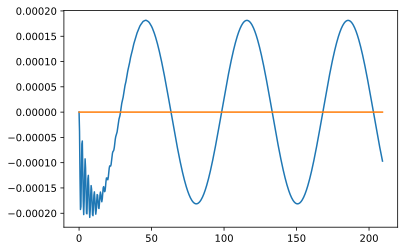

In [5]:
skip = 20
didx = 0
idx = slice(None)
tl = time_gatter(*tg)[::16]
plt.plot(tl[idx][::skip], texpect_v[idx,0,0][::skip].real)
plt.plot(tl[idx][::skip], texpect_v[idx,0,0][::skip].imag)

# raw conductity

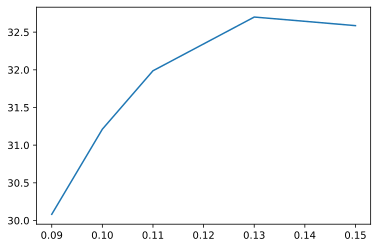

In [6]:
plt.plot(wpL, sigma.imag[0])
# or `(1.0/sigma).imag[0]` for voltage

In [7]:
fit, cov = jeff_fit_drude(systems['wp'], sigma)
Jeff = fit[..., 0] * fit[..., 1]
print(Jeff)

[8.937972]


# number operator in time thermalization test

[...] 
[...] rawrr!                              ,-""""""-.    OpenCL kernel v0.0
[...]                                  /\j__/\  (  \`--.    RK4 integrator
[...] Compile me,                      \`@_@'/  _)  >--.`.
[...] give me data                    _{.:Y:_}_{{_,'    ) )
[...] and I'll work that out 4u!     {_}`-^{_} ```     (_/
[...] 
[...] optimize the following dissipators:
[...] A(ω=3.0)
[...]  * <0|d|1> = (1+0j)
[...]  * <1|d|2> = (1.4142135381698608+0j)
[...]  * <2|d|3> = (1.7320507764816284+0j)
[...]  * <3|d|4> = (2+0j)
[...]  * <4|d|5> = (2.2360680103302+0j)
[...]  * <5|d|6> = (2.4494898319244385+0j)
[...]  * <6|d|7> = (2.6457512378692627+0j)
[...]  * <7|d|8> = (2.8284270763397217+0j)
[...] read 8 operators A(ω) requiring 24 operations per work-item.
[...] ... 4 operations have non-zero (>1e-05) contribution.
[...] precomiler: generating 1 x H_un, 0 x H_t, 4 x jump operations.
[...] generated kernel: 253 lines. Compiling...
[...] compute jumping structure...
[...] optimized

/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


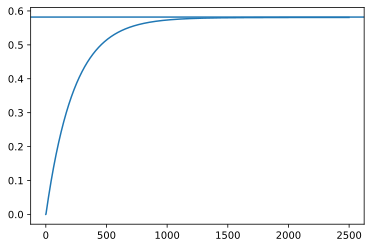

In [8]:
dimH = 9
t_bath = 3
rs = hosci.hosci_rs(dimH=dimH, EC=1, EJ=9)
texpect_v = opmesolve_cl_expect(
    tg=(0, 40, 0.001),
    reduced_system=rs,
    t_bath=t_bath,
    y_0=0.01,
    rho0=rs.thermal_state(T=0),
    Oexpect=hosci.On(n=dimH),
    rec_skip=16,
)
plt.plot(texpect_v)
plt.axhline(1.0/(np.exp(1.0/t_bath*3)-1))